In [1]:
import xarray as xr
from glob import glob
from datetime import datetime
import yaml
import sys
sys.path.append('../../')

import plotting

from conf.global_settings import OUTPUT_DIR
from utils.pipeline_utils.file_utils import get_date
from transformations.grid_transformation import Transformation

In [2]:
ds_name = "OISSS_L4_multimission_monthly_v2"
hemisphere = ''
with open(f'conf/ds_configs/{ds_name}.yaml', 'r') as stream:
    config = yaml.load(stream, yaml.Loader)

# Load sample granule

In [3]:
ds_granules_dir = f'{OUTPUT_DIR}/{ds_name}/harvested_granules/'
ds_granules = glob(f'{ds_granules_dir}/**/*.nc*')
if hemisphere:
    ds_granules = [g for g in ds_granules if hemisphere in g]
sample_granule_path = ds_granules[0]
print(sample_granule_path)

/Users/marlis/Developer/ECCO/ecco_output/OISSS_L4_multimission_monthly_v2/harvested_granules/2011/OISSS_L4_multimission_global_monthly_v2.0_2011-10.nc


In [4]:
filename_date_str = get_date(config['filename_date_regex'], sample_granule_path.split('/')[-1])
granule_date = datetime.strptime(filename_date_str, config['filename_date_fmt']).strftime('%Y-%m-%dT%H:%M:%SZ')
ds = xr.open_dataset(sample_granule_path)
ds

<xarray.Dataset>
Dimensions:                    (longitude: 1440, latitude: 720, time: 1)
Coordinates:
  * longitude                  (longitude) float32 -179.9 -179.6 ... 179.6 179.9
  * latitude                   (latitude) float32 -89.88 -89.62 ... 89.62 89.88
  * time                       (time) datetime64[ns] 2011-10-16
Data variables:
    sss                        (latitude, longitude, time) float32 ...
    sss_empirical_uncertainty  (latitude, longitude, time) float32 ...
    sss_formal_uncertainty     (latitude, longitude, time) float32 ...
    sss_climatology            (latitude, longitude, time) float32 ...
    sss_anomaly                (latitude, longitude, time) float32 ...
Attributes: (12/42)
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      CF Standard Name Table v27
    Title:                         Multi-Mission Optimally Interpolated Sea S...
    Short_Name:                    OISSS_L4_multimission_v2_monthly
    Version:                       V2.0
    Processing_Level:              Level 4
    ...                            ...
    geospatial_lat_resolution:     0.25
    geospatial_lat_units:          degrees_north
    geospatial_lon_min:            -180.0
    geospatial_lon_max:            180.0
    geospatial_lon_resolution:     0.25
    geospatial_lon_units:          degrees_east

# Load grid

In [5]:
grids = glob(f'grids/*.nc*')
grids.sort()
f'Available grids: {grids}'

"Available grids: ['grids/ECCO_llc270.nc', 'grids/ECCO_llc90.nc', 'grids/TPOSE.nc', 'grids/polar_stereo_n_25km.nc']"

In [6]:
grid_ds = xr.open_dataset(grids[1])
grid_ds

<xarray.Dataset>
Dimensions:                (tile: 13, j: 90, i: 90)
Coordinates:
  * tile                   (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                      (j) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i                      (i) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Data variables:
    XC                     (tile, j, i) float32 ...
    YC                     (tile, j, i) float32 ...
    effective_grid_radius  (tile, j, i) float32 ...
Attributes:
    name:                  ECCO_llc90
    type:                  llc
    geospatial_lat_min:    -89.873055
    geospatial_lat_max:    89.739395
    geospatial_lon_min:    -179.98895
    geospatial_lon_max:    179.98691
    geospatial_lat_units:  degrees_north
    geospatial_lon_units:  degrees_east

In [7]:
T = Transformation(config, sample_granule_path, granule_date)

# Make mapping factors

In [8]:
factors = T.make_factors(grid_ds)

/Users/marlis/opt/anaconda3/envs/ecco_pipeline/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Only using 100 nearest neighbours, but you may need up to 6375938


/Users/marlis/opt/anaconda3/envs/ecco_pipeline/lib/python3.10/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 100 neighbours within 77123 m for some data points
  warnings.warn(('Possible more than %s neighbours '


0 %
5 %
10 %
15 %
21 %
26 %
31 %
36 %
42 %
47 %
52 %
57 %
63 %
68 %
73 %
78 %
84 %
89 %
94 %


# Transformation

In [9]:
field_ds_list = T.transform(grid_ds, factors, ds)

In [10]:
field_ds = field_ds_list[0][0]
field_ds

<xarray.Dataset>
Dimensions:                         (time: 1, tile: 13, j: 90, i: 90, nv: 2)
Coordinates:
  * time                            (time) datetime64[ns] 2011-10-16T12:00:00
  * tile                            (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                               (j) int16 0 1 2 3 4 5 ... 84 85 86 87 88 89
  * i                               (i) int16 0 1 2 3 4 5 ... 84 85 86 87 88 89
    XC                              (tile, j, i) float32 -111.6 ... -111.9
    YC                              (tile, j, i) float32 -88.24 -88.38 ... -88.1
    time_bnds                       (time, nv) datetime64[ns] 2011-10-01 2011...
Dimensions without coordinates: nv
Data variables:
    sss_interpolated_to_ECCO_llc90  (time, tile, j, i) float64 9.969e+36 ... ...
Attributes:
    interpolated_grid:            ECCO_llc90
    model_grid_type:              llc
    original_dataset_title:       Multi-Mission Optimally Interpolated Sea Su...
    original_dataset_short_name:  OISSS_L4_multimission_monthly_v2
    original_dataset_url:         https://podaac.jpl.nasa.gov/dataset/OISSS_L...
    original_dataset_reference:   http://smap.jpl.nasa.gov/
    original_dataset_doi:         10.1002/2015JC011343
    interpolated_grid_id:         ECCO_llc90
    transformation_version:       1.2
    notes:

# Visualization

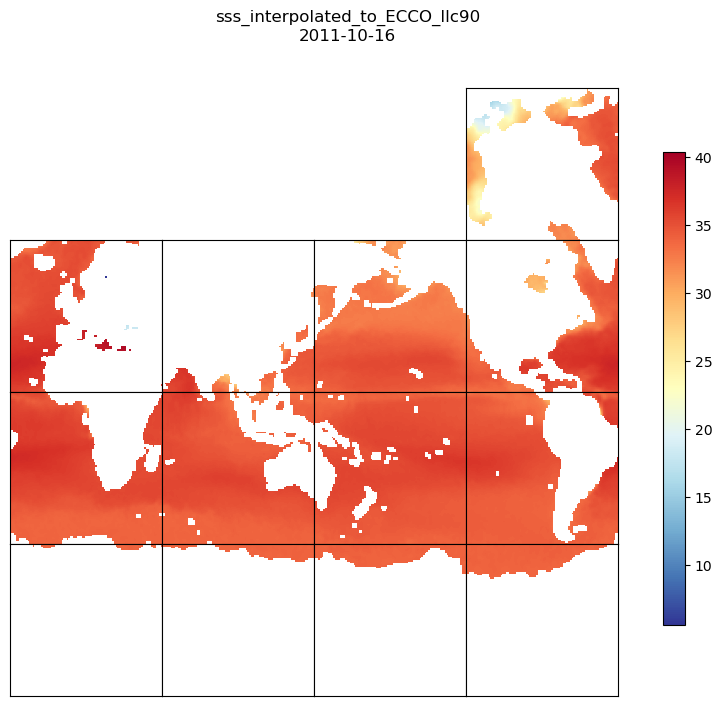

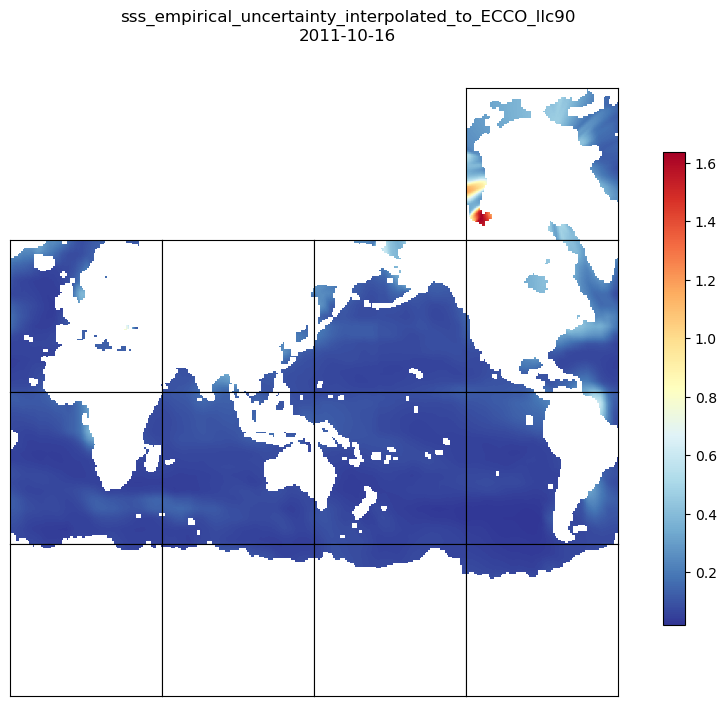

In [18]:
for field_ds in field_ds_list:
    data_var = list(field_ds[0].data_vars)[0]
    plotting.make_plot(field_ds[0][data_var])